<i><span style="color:#e74c3c;"><b>MAIN GOAL: </b>  I tried to an answer and question project with fine-tuned Gemma 7B model using prompts.</span></i>


* I applied several <b>preprocessing</b> operations (cleaning,dropping stop words etc.),
* I created <b>Gemma prompts</b>,
* I fine-tuned a Gemma 7B model with <b>LoRA</b>,
* I have modified this notebook [1],
* An end-2-end test prediction pipeline function,
* Test evaluation metrics <b>(mean cosine similarity, mean BLEU Score)</b>,


## Test Predictions
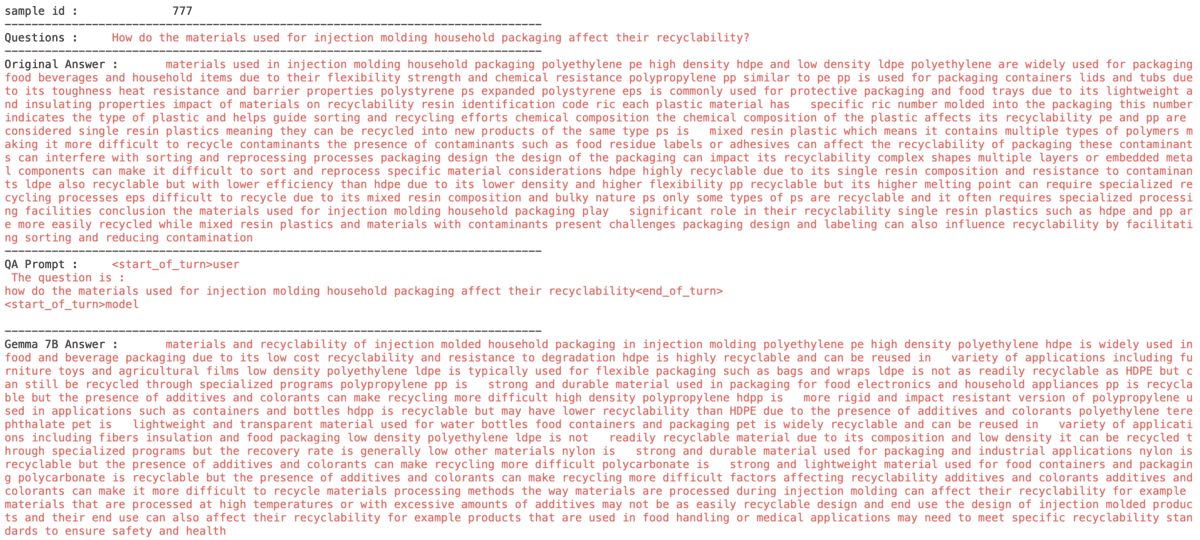


## My Another Projects
* [News Zero-Shot Topic Modelling w/BERTopic](https://www.kaggle.com/code/banddaniel/news-zero-shot-topic-modelling-w-bertopic)
* [Complaint Analysis w/Ensemble Model (CatBoost, LR)](https://www.kaggle.com/code/banddaniel/complaint-analysis-w-ensemble-model-catboost-lr)


## References
1. https://ai.google.dev/gemma/docs/lora_tuning

In [1]:
from IPython.display import clear_output
!pip install -q tensorflow-cpu
!pip install -q -U keras-nlp tensorflow-hub
!pip install -q -U keras>=3
!pip install -U tensorflow-text
!pip install nltk colorama
!pip install sentence-transformers
clear_output()

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.9"

import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import string
from colorama import Fore, Back, Style
import pprint
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

import keras
import keras_nlp
import jax
import tensorflow as tf

from sentence_transformers import SentenceTransformer
sim_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

SEED = 99

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# <span style="color:#e74c3c;"> Reading </span> Data

In [3]:
# reading, dropping and shuffling
data = pd.read_csv('/kaggle/input/injection-molding-qa/dataset.csv')
data.drop_duplicates(subset = ['Questions', 'Answers'], inplace = True)
data = data.sample(frac = 1, random_state = SEED).reset_index(drop = True)
data.head()

,Questions,Answers
0,What are the common signs and symptoms of inje...,**Common Signs and Symptoms of Injection Moldi...
1,How is the injection molding industry regulate...,**Regulation of the Injection Molding Industry...
2,How can you prevent electrical problems in inj...,**Preventing Electrical Problems in Injection ...
3,How can the precision and accuracy of micro-in...,**Improving Precision and Accuracy in Micro-In...
4,What are the different types of research and d...,**Different Types of Research and Development ...


# <span style="color:#e74c3c;"> Preprocessing </span>

In [4]:
%%time
# preprocessing functions
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def text_preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'\[.*?\]', ' ', text)
    text = re.sub(r'@\w+\s*', ' ', text)
    text = re.sub(r'\\W',' ',text) 
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'http', ' ', text)
    text = re.sub(r'<.*?>+', ' ', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', ' ', text)
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]', ' ', text)
    return text


def delete_one_characters(text):
    deleted = [word if len(word)>1 else " " for word in text.split()]
    final_text = ' '.join(deleted)
    return final_text


# applying preprocessing functions 
full_data = data.copy()
full_data['preprocessed_Answers'] = data['Answers'].apply(text_preprocessing).apply(delete_one_characters)
full_data['preprocessed_Questions'] = data['Questions'].apply(text_preprocessing).apply(delete_one_characters)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


CPU times: user 2.52 s, sys: 12.1 ms, total: 2.54 s
Wall time: 2.65 s


In [5]:
full_data.head()

,Questions,Answers,preprocessed_Answers,preprocessed_Questions
0,What are the common signs and symptoms of inje...,**Common Signs and Symptoms of Injection Moldi...,common signs and symptoms of injection molding...,what are the common signs and symptoms of inje...
1,How is the injection molding industry regulate...,**Regulation of the Injection Molding Industry...,regulation of the injection molding industry t...,how is the injection molding industry regulate...
2,How can you prevent electrical problems in inj...,**Preventing Electrical Problems in Injection ...,preventing electrical problems in injection mo...,how can you prevent electrical problems in inj...
3,How can the precision and accuracy of micro-in...,**Improving Precision and Accuracy in Micro-In...,improving precision and accuracy in micro inje...,how can the precision and accuracy of micro in...
4,What are the different types of research and d...,**Different Types of Research and Development ...,different types of research and development ac...,what are the different types of research and d...


# <span style="color:#e74c3c;"> Dataset </span> Splitting

In [6]:
train_data, test_data = train_test_split(full_data, test_size = 0.1, random_state = SEED)

train_data.reset_index(drop = True, inplace = True)
test_data.reset_index(drop = True, inplace = True)

print('train samples :\t', train_data.shape[0])
print('test samples :\t', test_data.shape[0])

train samples :	 4500
test samples :	 500


# <span style="color:#e74c3c;"> Creating </span> Prompts

In [7]:
def create_instruct_dataset(df: pd.DataFrame, for_train : bool) -> np.array :
    dataset = []
    for index, row in df.iterrows():
        question, answer = row['preprocessed_Questions'], row['preprocessed_Answers']
        
        if for_train:
            template = (f"<start_of_turn>user\n The question is :\n{question}<end_of_turn>\n<start_of_turn>model\n{answer}'<end_of_turn>")
        else:
            template = (f"<start_of_turn>user\n The question is :\n{question}<end_of_turn>\n<start_of_turn>model\n")
        dataset.append(template)
        
    return dataset

In [8]:
%%time
train_dataset = create_instruct_dataset(train_data, True)
test_dataset = create_instruct_dataset(test_data, False)

CPU times: user 216 ms, sys: 0 ns, total: 216 ms
Wall time: 216 ms


In [9]:
# a train prompt example
print(train_dataset[10])

<start_of_turn>user
 The question is :
how can online training courses help injection molding professionals improve their skills<end_of_turn>
<start_of_turn>model
how can online training courses help injection molding professionals improve their skills online training courses can help injection molding professionals improve their skills in several ways convenience and flexibility online courses allow professionals to learn at their own pace and on their own schedule without having to travel or attend in person classes this makes it easy to fit training into their busy work schedules access to experts online courses often feature instruction from industry experts who have years of experience in injection molding this provides professionals with access to the latest knowledge and best practices in the field interactive content online courses typically include interactive content such as videos simulations and quizzes which helps to reinforce learning and make the training more engaging h

# <span style="color:#e74c3c;"> Gemma 7B</span> Model

In [10]:
devices = jax.devices("tpu")
device_mesh = keras.distribution.DeviceMesh((1, 8), ["batch", "model"], devices=keras.distribution.list_devices())

model_dim = "model"

layout_map = keras.distribution.LayoutMap(device_mesh)

layout_map["token_embedding/embeddings"] = (None, model_dim)
layout_map["decoder_block.*attention.*(query|key|value).*kernel"] = (None, model_dim, None)
layout_map["decoder_block.*attention_output.*kernel"] = (None, None, model_dim)
layout_map["decoder_block.*ffw_gating.*kernel"] = (model_dim, None)
layout_map["decoder_block.*ffw_linear.*kernel"] = (None, model_dim)

E0402 19:34:13.983688713     376 oauth2_credentials.cc:238]            oauth_fetch: UNKNOWN:C-ares status is not ARES_SUCCESS qtype=A name=metadata.google.internal. is_balancer=0: Domain name not found {grpc_status:2, created_time:"2024-04-02T19:34:13.983671583+00:00"}


In [11]:
model_parallel = keras.distribution.ModelParallel(device_mesh, layout_map, batch_dim_name="batch")
keras.distribution.set_distribution(model_parallel)
gemma = keras_nlp.models.GemmaCausalLM.from_preset("gemma_instruct_7b_en")

Attaching 'config.json' from model 'keras/gemma/keras/gemma_instruct_7b_en/2' to your Kaggle notebook...


Attaching 'config.json' from model 'keras/gemma/keras/gemma_instruct_7b_en/2' to your Kaggle notebook...


Attaching 'model.weights.h5' from model 'keras/gemma/keras/gemma_instruct_7b_en/2' to your Kaggle notebook...


Attaching 'tokenizer.json' from model 'keras/gemma/keras/gemma_instruct_7b_en/2' to your Kaggle notebook...


Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/gemma/keras/gemma_instruct_7b_en/2' to your Kaggle notebook...


normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [12]:
# enabled lora
gemma.backbone.enable_lora(rank=4)

gemma.preprocessor.sequence_length = 256

optimizer = keras.optimizers.AdamW(learning_rate=5e-5, weight_decay=0.01, beta_1=0.9, beta_2=0.999)
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=optimizer, weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()])

my_callbacks = [keras.callbacks.EarlyStopping(monitor = 'loss',patience = 2, min_delta = 0.001)]

gemma.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 3072)        │   8,548,748,288 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     786,432,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 8,548,748,288 (31.85 GB)

 Trainable params: 11,067,392 (42.22 MB)

 Non-trainable params: 8,537,680,896 (31.81 GB)

# <span style="color:#e74c3c;"> Gemma 7B</span> Fine-Tuning

In [ ]:
# fine-tuning
gemma.fit(train_dataset, epochs = 6, batch_size = 1, callbacks = my_callbacks)

# <span style="color:#e74c3c;"> Test</span> Predictions

In [14]:
# a function for creating test pipeline
# random test id -> generate with gemma -> split prediction

def predict_test_sample(original_df : pd.DataFrame, generated_prompt_arr : np.array, SEED: int = None):
    
    idx = np.random.default_rng(seed=SEED).permutation(original_df.shape[0])[0]
    print("sample id : \t\t", idx)
    print("--"*40)
    print("Questions :\t" +Fore.RED + original_df.iloc[idx].Questions + Style.RESET_ALL)
    
    print("--"*40)
    print("Original Answer :\t" +Fore.RED + original_df.iloc[idx].preprocessed_Answers + Style.RESET_ALL)

    print("--"*40)
    print("QA Prompt :\t" +Fore.RED + generated_prompt_arr[idx] + Style.RESET_ALL)
    print("--"*40)

    # gemma generated
    gemma_answer = gemma.generate(generated_prompt_arr[idx])
    final_gemma_answer = re.sub("'<end_of_turn>", ' ', re.split("<start_of_turn>model\n", gemma_answer)[-1])
    print("Gemma 7B Answer :\t" +Fore.RED + final_gemma_answer + Style.RESET_ALL)

In [15]:
# a random test answer with gemma
predict_test_sample(test_data, test_dataset, 954)

sample id : 		 428
--------------------------------------------------------------------------------
Questions :	**Product Design and Development**
--------------------------------------------------------------------------------
Original Answer :	product design and development for injection molding material selection consider the desired properties such as strength rigidity toughness temperature resistance and chemical resistance choose materials suitable for injection molding processes such as thermoplastics thermosets or elastomers part geometry design parts with uniform wall thickness to prevent sink marks and warping avoid sharp corners or thin sections that can lead to mold sticking or breakage consider draft angles and radii to facilitate ejection from the mold tolerances and dimensions specify realistic tolerances based on the capabilities of the injection molding process account for mold shrinkage which can vary depending on the material and process parameters use proper units o

Gemma 7B Answer :	product design and development in injection molding part design and simulation part design involves creating   digital model of the part   desired shape and dimensions this model is then imported into simulation software where it undergoes finite element analysis fea to verify its manufacturability and functionality mold design mold design involves creating   digital model of the mold   caging and cavities this model is used to generate the toolpaths that guide the mold cutting tools during machining injection molding machine setup and operation the injection molding machine is set up with the mold and the appropriate material the machine   parameters such as injection pressure temperature and cycle time are optimized for the specific part and mold mold operation and maintenance the mold is cleaned and lubricated regularly to prevent sticking and wear the mold   caging and cavities are inspected regularly for any damage that could affect part quality product developme

In [16]:
# a random test answer with gemma
predict_test_sample(test_data, test_dataset, 23)

sample id : 		 68
--------------------------------------------------------------------------------
Questions :	What are the potential causes of problems with mold repair?
--------------------------------------------------------------------------------
Original Answer :	potential causes of problems with mold repair incorrect diagnosis misidentifying the root cause of the problem can lead to ineffective or inadequate repairs insufficient material strength using   repair material that is not strong enough to withstand the molding process can result in premature failure poor surface preparation inadequate cleaning or preparation of the mold surface before repair can compromise the bond between the repair material and the mold improper bonding incomplete or faulty bonding can cause the repair material to separate from the mold leading to leaks or defects in the molded parts mold distortion heat or pressure during the repair process can cause the mold to distort affecting its functionality a

Gemma 7B Answer :	potential causes of problems with mold repair insufficient preparation not properly cleaning removing old adhesives and preparing the surface to ensure proper bonding of adhesives and sealants using the wrong adhesives not selecting adhesives that are compatible with the material and application conditions overtightening applying excessive force when assembling or tightening mold parts causing damage or deformation to components improper sealing not applying sufficient sealant or not choosing the appropriate sealant for the application leading to leaks and contamination contamination dirt dust or contaminants on the mold surfaces or adhesive can interfere with adhesion and cause bonding failure incorrect temperature applying adhesives or sealants at temperatures below or above their recommended ranges can impact their strength and performance environmental factors changes in humidity temperature or exposure to uv radiation can affect adhesive performance and bonding s

In [17]:
# a random test answer with gemma
predict_test_sample(test_data, test_dataset, 863)

sample id : 		 406
--------------------------------------------------------------------------------
Questions :	What are the signs that an injection mold needs maintenance?
--------------------------------------------------------------------------------
Original Answer :	signs of an injection mold needing maintenance visible defects on molded parts this can include sink marks flashes weld lines short shots or bubbles reduced cycle time slow molding cycles indicate potential issues with the mold such as sticking or poor heat transfer increased clamping force required higher than normal clamping force may indicate wear or misalignment of mold components noisy operation grinding squealing or popping sounds can be   sign of damaged or worn mold components increased mold temperature excessive mold temperature can indicate poor cooling or lubrication leaks mold leakage from around the parting line or cooling lines can indicate damage or wear sticking parts difficulties in ejecting molded par

Gemma 7B Answer :	signs that an injection mold needs maintenance short shots or incomplete part formation part surface defects scratches voids or discoloration increased cycle time or slower molding cycle pressure fluctuations inconsistent or erratic flow of material reduced part quality or increased defect rates flash material leaking around the mold parting line warpage or distortion of the molded part mold temperature fluctuations significant changes in mold temperature affecting part quality material discoloration or stains on the mold surface signs of mold fouling or contamination material buildup or residue inside the mold cavity or runners reduced flowability or blockage of material in the mold corrosion or rust on mold components increased wear and tear of mold components such as ejectors pins or heaters 


# <span style="color:#e74c3c;"> Test Dataset</span> Evaluation

In [18]:
# a function for predict the full dataset

def prediction_func(original_df : pd.DataFrame, generated_prompt_arr : np.array):
    
    original_answers = test_data['preprocessed_Answers'].values
    gemma_answers = []
    
    for idx in tqdm(range(original_df.shape[0]), desc = 'Generated Answer'):
        gemma_answer = gemma.generate(generated_prompt_arr[idx])
        final_gemma_answer = re.sub("'<end_of_turn>", ' ', re.split("<start_of_turn>model\n", gemma_answer)[-1])
        gemma_answers.append(final_gemma_answer)

    
    return original_answers, gemma_answers

In [ ]:
%%time
original_answers, gemma_pred_answers = prediction_func(test_data, test_dataset)

In [20]:
# test evaluation function
# return1 -> the mean of cosine similarity of original answers and gemma predictions
# return2 -> the mean of bleu scores of original answers and gemma predictions


def test_evaluation(original_answers, pred_answers):
    
    # cosine similarities
    original_answers_embeddings = sim_model.encode(original_answers)
    gemma_pred_answers_embeddings = sim_model.encode(pred_answers)
    
    cos_sims = []
    for i in range(original_answers_embeddings.shape[0]):
        similarities = cosine_similarity(original_answers_embeddings[i].reshape(1,-1), gemma_pred_answers_embeddings[i].reshape(1,-1))
        cos_sims.append(similarities[0][0])
    
    # blue scores
    smoothie = SmoothingFunction()
    
    bleu_scores = []
    for i in range(len(original_answers)):
        bleu_score = sentence_bleu([original_answers[i].split()], pred_answers[i].split(), smoothing_function=smoothie.method1)
        bleu_scores.append(bleu_score)
        
        
    return np.mean(cos_sims, axis = 0), np.mean(bleu_scores, axis = 0) 

In [21]:
# final test evaluations
cosine_similarity, mean_bleu_score = test_evaluation(original_answers, gemma_pred_answers)

print('Mean Cosine Similarity : ', cosine_similarity)
print('Mean BLEU Score : ', mean_bleu_score)

Mean Cosine Similarity :  0.83046055
Mean BLEU Score :  0.09372312291706567
